In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, math, pandas, numpy.random as npr, multiprocessing as mp, copy
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from tqdm import trange
from ecology_functions import *

In [2]:
def p_1(sigma, epsilon, A) :
    return epsilon*(sigma<epsilon) + sigma*(epsilon<=sigma<=A) + A*(sigma>A)

def p_2(Sigma, A) :
    absSigma = np.linalg.norm(Sigma)
    return Sigma*(absSigma<=A) + (A/absSigma)*Sigma*(absSigma>=A)

def p_3(x, A) :
    absx = np.abs(x)
    return x*(absx<=A) + (A/absx)*x*(absx>A)

In [3]:
def adapt(theta, mu, Gamma, sigma, gamma, accept_prob, taubar, epsilon_1, A, update) :
    alpha, lmbda, c, phi, logsigmasq = theta[:]
    mu_alpha, mu_lmbda, mu_c, mu_phi, mu_logsigmasq = mu[:]
    Gamma_alpha, Gamma_lmbda, Gamma_c, Gamma_phi, Gamma_logsigmasq = Gamma[:]
    
    for i in range(5) :
        if update[i] : 
            mu[i] = p_3(mu[i] + gamma*(theta[i].flatten()-mu[i]), A) 
            Gamma[i] = p_2(Gamma[i] + gamma*((theta[i].flatten()-mu[i])*((theta[i].flatten()-mu[i]).transpose()) - Gamma[i]), A)
    
    sigma = p_1(sigma + gamma*(accept_prob-taubar), epsilon_1, A)
    
    return mu, Gamma, sigma

In [4]:
def propose_MALA(theta, grad, sigma, Gamma, epsilon_2, update) :
    npr.seed()
    scipy.random.seed()
    
    shapes = [np.prod(np.shape(theta[i])).astype(int) for i in range(5)]
    Lmbda = [Gamma[i] + epsilon_2*np.eye(shapes[i]) for i in range(5)]
    prop = [theta[i].flatten() + update[i]*(sigma**2*np.diag(Lmbda[i])*(grad[i].flatten()) \
                                  + np.sqrt(2*sigma**2*np.diag(Lmbda[i]))*npr.randn(shapes[i])) \
            for i in range(5)]
    
    return [np.reshape(prop[i], np.shape(theta[i])) for i in range(5)]

In [5]:
def transition_prob_MALA(theta_curr, theta_prop, ll_curr, ll_prop, grad_curr, grad_prop, 
                         sigma, Gamma, epsilon_2, power, update) :
    log_prior_curr, log_prior_prop = log_prior(theta_curr), log_prior(theta_prop) 
    a = power*(ll_prop-ll_curr) + (log_prior_prop-log_prior_curr)
    
    J, K = np.shape(theta_curr[1])
    
    tau_alpha = sigma*2*np.diag(Gamma[0] + epsilon_2*np.eye(J))
    tau_lmbda = sigma*2*np.diag(Gamma[1] + epsilon_2*np.eye(J*K))
    tau_c = sigma*2*np.diag(Gamma[2] + epsilon_2*np.eye(1))
    tau_phi = sigma*2*np.diag(Gamma[3] + epsilon_2*np.eye(1))
    tau_logsigmasq = sigma*2*np.diag(Gamma[4] + epsilon_2*np.eye(1))
    
    tau = [tau_alpha, np.reshape(tau_lmbda, [J,K]), tau_c, tau_phi, tau_logsigmasq]
    
    b1 = -np.sum([np.linalg.norm((theta_curr[i] - theta_prop[i] - update[i]*tau[i]*grad_curr[i])/(2*np.sqrt(tau[i])))**2 \
                  for i in range(5)])
    b2 = -np.sum([np.linalg.norm((theta_prop[i] - theta_curr[i] - update[i]*tau[i]*grad_prop[i])/(2*np.sqrt(tau[i])))**2 \
                  for i in range(5)])
    return a + b1 - b2

In [6]:
def pMCMC_MALA_blockPF_adaptive(Y, x_0, n_particles, theta_0, n_mcmc, sigma, Gamma, mu, 
                                gamma, A, epsilon_1, epsilon_2, taubar, update, power=1) :
    
    np.random.seed()
    scipy.random.seed()
    
    alpha_chain, lmbda_chain, c_chain, phi_chain, logsigmasq_chain, lls, theta_mu, theta_m2 = initialise(theta_0, n_mcmc)
    theta_chain = [alpha_chain, lmbda_chain, c_chain, phi_chain, logsigmasq_chain]
    
    theta_curr = [alpha_chain[0], lmbda_chain[0], c_chain[0], phi_chain[0], logsigmasq_chain[0]]    
    ll_curr, grad_curr = block_PF(Y, x_0, n_particles, theta_curr, calc_grad=True)
    accepted = 0
    last_jump = 0
    
    accept_probs = np.zeros(n_mcmc)
    sigma_vals = np.zeros(n_mcmc+1)
    sigma_vals[0] = sigma
    
    for n in trange(n_mcmc) :
        theta_prop = propose_MALA(theta_curr, grad_curr, sigma_vals[n], Gamma, epsilon_2, update)
        ll_prop, grad_prop = block_PF(Y, x_0, n_particles, theta_prop, calc_grad=True)
        log_accept_prob = transition_prob_MALA(theta_curr, theta_prop, ll_curr, ll_prop, grad_curr, grad_prop, 
                                               sigma, Gamma, epsilon_2, power, update)
        accept_probs[n] = np.exp(log_accept_prob)
        
        if np.log(npr.rand()) < log_accept_prob :
            ll_curr = np.copy(ll_prop)
            theta_curr = np.copy(theta_prop)
            grad_curr = np.copy(grad_prop)
            accepted += 1
            last_jump = n
        else :
            if n - last_jump > 50 :
                ll_curr, grad_curr = block_PF(Y, x_0, n_particles, theta_curr, calc_grad=True)
        mu, Gamma, sigma_vals[n+1] = adapt(theta_curr, mu, Gamma, sigma_vals[n], gamma[n], 
                                           accept_probs[n], taubar, epsilon_1, A, update)
       
        theta_chain = push(theta_chain, theta_curr, n+1)

    print(100*accepted/n_mcmc, "% acceptance rate")
    return theta_chain, accept_probs, sigma_vals

### Simulate artificial observations:

In [7]:
T = 100
I = 5    # number of locations
J = 3    # number of species
K = 2    # number of latent factors

In [8]:
lmbda = npr.randn(J,K)
alpha = npr.randn(J)
c = 0
phi = 0.5
logsigmasq = 0
x_0 = npr.randn(I,K)

theta = [alpha, lmbda, c, phi, logsigmasq]
Y, X = simulate_data(x_0, T, J, theta)

#### Initialise:

In [9]:
mu_alpha = 1e-4*np.ones(J)
mu_lmbda = 1e-4*np.ones(J*K)
mu_c = 1e-4
mu_phi = 1e-4
mu_logsigmasq = 1e-4
mu = [mu_alpha, mu_lmbda, mu_c, mu_phi, mu_logsigmasq]

sigma = 1e-2

In [10]:
A = 1e1
epsilon_1 = 1e-4
epsilon_2 = 1e-4

Gamma_alpha = np.eye(J)/100
Gamma_lmbda = np.eye(J*K)/100
Gamma_c = np.eye(1)/100
Gamma_phi = np.eye(1)/100
Gamma_logsigmasq = np.eye(1)/100
Gamma = [Gamma_alpha, Gamma_lmbda, Gamma_c, Gamma_phi, Gamma_logsigmasq]

In [12]:
taubar = 0.15
n_mcmc = 200
gamma = 0.5/np.arange(1,n_mcmc+1)

### Run MCMC:

In [13]:
n_particles = 1000
update = [1, 0, 0, 0, 0]
theta_chain, accept_probs, sigma_vals = pMCMC_MALA_blockPF_adaptive(Y, x_0, n_particles, theta, n_mcmc, sigma, Gamma, mu, 
                                                        gamma, A, epsilon_1, epsilon_2, taubar, update, power=1)

/home/postdoc/dsen/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)
100%|██████████| 200/200 [01:35<00:00,  2.72it/s]

1.5 % acceptance rate


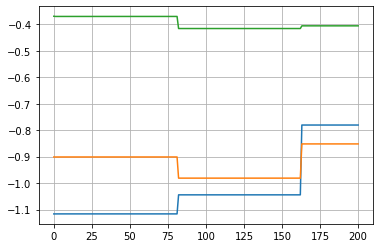

In [14]:
plt.plot(theta_chain[0])
plt.grid(True)

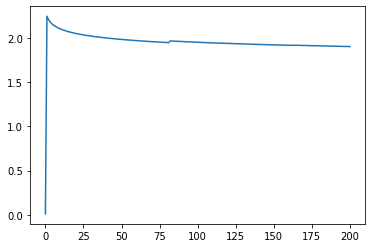

In [16]:
plt.plot(sigma_vals)